In [1]:
import os
import utils
import model_scoring
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io.export import get_screenshot_as_png
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input

Using plaidml.keras.backend backend.


In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
train, test = utils.load_data()

Now, we will normalize the data.

In [4]:
mean = train.mean(axis=0)
std = train.std(axis=0)

utils.preprocess(train, mean, std)
utils.preprocess(test, mean, std)

In [5]:
labels = train['target'].tolist()
train.drop(columns=['target'], inplace=True)
train.head()

,PRCP,TMAX,TMIN,day_of_year_1,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2005-03-03,-0.364319,-1.644261,-1.547583,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2016-01-17,-0.238134,-1.149823,-1.126503,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-06-06,0.115184,0.718051,0.678123,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2010-08-18,-0.364319,1.267426,1.399974,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2011-09-29,0.645160,0.553239,0.738277,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [6]:
main_input = Input(shape=(train.shape[1],), name='main_input')

x = Dense(128, activation='relu')(main_input)
x = Dropout(.25)(x)
x = Dense(64, activation='relu')(x)

output = Dense(1, name='output')(x)

model = Model(inputs=[main_input], outputs=output)
model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_rx_580.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 441)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               56576     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 64,897
Trainable params: 64,897
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])
history = model.fit([train], labels,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                   )

Train on 3969 samples, validate on 993 samples
Epoch 1/20
3969/3969 [==============================] - 1s 144us/step - loss: 0.2599 - mean_absolute_error: 0.3593 - val_loss: 0.1077 - val_mean_absolute_error: 0.2420
Epoch 2/20
3969/3969 [==============================] - 0s 120us/step - loss: 0.1238 - mean_absolute_error: 0.2552 - val_loss: 0.0842 - val_mean_absolute_error: 0.2199
Epoch 3/20
3969/3969 [==============================] - 0s 116us/step - loss: 0.1028 - mean_absolute_error: 0.2324 - val_loss: 0.1273 - val_mean_absolute_error: 0.2635
Epoch 4/20
3969/3969 [==============================] - 1s 129us/step - loss: 0.0961 - mean_absolute_error: 0.2217 - val_loss: 0.1144 - val_mean_absolute_error: 0.2450
Epoch 5/20
3969/3969 [==============================] - 0s 119us/step - loss: 0.0882 - mean_absolute_error: 0.2155 - val_loss: 0.0849 - val_mean_absolute_error: 0.2114
Epoch 6/20
3969/3969 [==============================] - 0s 118us/step - loss: 0.0828 - mean_absolute_error: 0.210

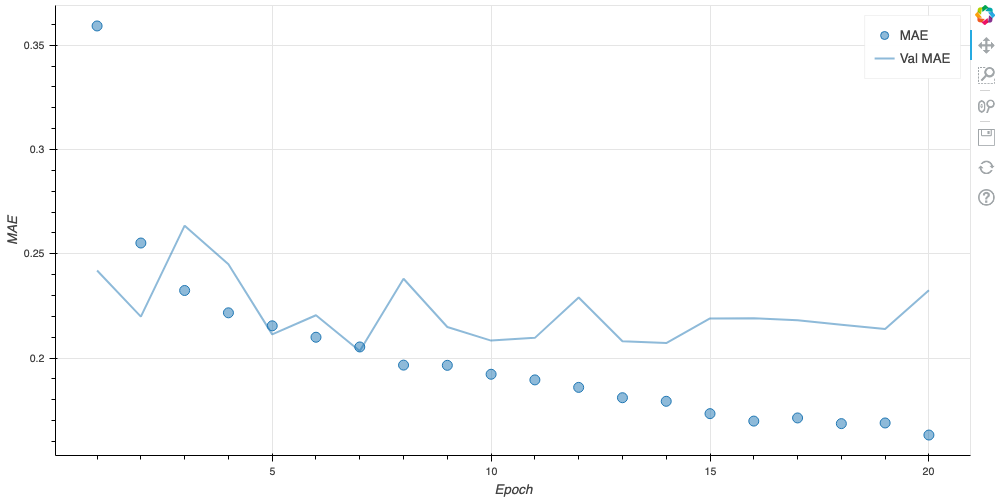

In [8]:
source = pd.DataFrame(history.history)
source['epoch'] = source.index + 1
acc_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='MAE')
acc_plot.circle(x='epoch', y='mean_absolute_error', source=source, size=10, fill_alpha=.5, legend_label='MAE')
acc_plot.line(x='epoch', y='val_mean_absolute_error', source=source, line_width=2, legend_label='Val MAE', alpha=0.5)
# show(acc_plot)
get_screenshot_as_png(acc_plot, driver=None)

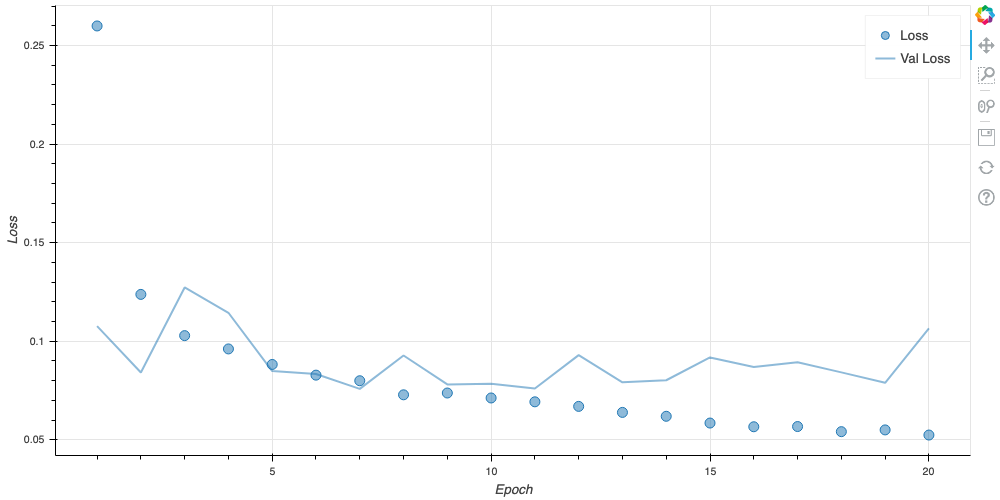

In [9]:
loss_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='Loss')
loss_plot.circle(x='epoch', y='loss', source=source, size=10, fill_alpha=.5, legend_label='Loss')
loss_plot.line(x='epoch', y='val_loss', source=source, line_width=2, legend_label='Val Loss', alpha=0.5)
# show(loss_plot)
get_screenshot_as_png(loss_plot, driver=None)

In [10]:
predictions = model.predict(test.copy().drop(columns=['target']))
isolf = utils.isolf()
results = test.join(isolf, how='inner')
results['prediction'] = predictions
results['target'] *= std.target
results['target'] += mean.target
results['prediction'] *= std.target
results['prediction'] += mean.target
results['date'] = results.index
results

,target,PRCP,TMAX,TMIN,day_of_year_1,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,month_8,month_9,month_10,month_11,month_12,isolf_min,isolf_max,isolf_mean,prediction,date
2018-09-08,5953.126027,-0.313845,0.443364,0.738277,0,0,0,0,0,0,...,0,1,0,0,0,5335.0,6416.0,5971.416667,5411.363770,2018-09-08
2016-10-04,5629.877740,-0.364319,0.333489,0.678123,0,0,0,0,0,0,...,0,0,1,0,0,4333.0,6519.0,5723.541667,5913.917480,2016-10-04
2005-06-18,5531.163946,-0.364319,0.718051,0.798431,0,0,0,0,0,0,...,0,0,0,0,0,4451.0,6112.0,5426.750000,5593.401367,2005-06-18
2015-08-27,6918.359459,-0.364319,1.047676,1.099202,0,0,0,0,0,0,...,1,0,0,0,0,5587.0,8270.0,7154.708333,6829.250488,2015-08-27
2018-10-29,5384.917708,-0.288608,-0.380698,-0.103882,0,0,0,0,0,0,...,0,0,1,0,0,4000.0,6070.0,5332.000000,5548.815918,2018-10-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-07,5929.614189,0.443264,-2.028823,-1.728046,0,0,0,0,0,0,...,0,0,0,0,0,4836.0,6415.0,5741.916667,5854.972168,2017-01-07
2012-12-03,5645.595862,-0.364319,-0.160948,0.016427,0,0,0,0,0,0,...,0,0,0,0,1,4224.0,6795.0,5718.000000,5612.569336,2012-12-03
2006-02-15,5875.283333,-0.364319,-0.380698,-0.765578,0,0,0,0,0,0,...,0,0,0,0,0,4420.0,6701.0,5818.375000,5742.966309,2006-02-15
2005-04-19,5610.283390,-0.364319,0.772989,0.076581,0,0,0,0,0,0,...,0,0,0,0,0,3906.0,6707.0,5640.625000,5633.625488,2005-04-19


In [11]:
results = results.sort_index()
results

,target,PRCP,TMAX,TMIN,day_of_year_1,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,month_8,month_9,month_10,month_11,month_12,isolf_min,isolf_max,isolf_mean,prediction,date
2005-03-04,5951.496552,-0.364319,-1.479448,-1.547583,0,0,0,0,0,0,...,0,0,0,0,0,4573.0,6846.0,5970.250000,5963.976074,2005-03-04
2005-03-15,5885.332639,-0.364319,-0.930073,-1.246812,0,0,0,0,0,0,...,0,0,0,0,0,4425.0,6646.0,5833.458333,5996.581055,2005-03-15
2005-03-16,5797.381724,-0.364319,-0.985011,-1.006195,0,0,0,0,0,0,...,0,0,0,0,0,4503.0,6683.0,5883.500000,5904.235352,2005-03-16
2005-04-14,5507.621379,-0.364319,0.168676,-0.284344,0,0,0,0,0,0,...,0,0,0,0,0,4030.0,6333.0,5490.625000,5442.619629,2005-04-14
2005-04-19,5610.283390,-0.364319,0.772989,0.076581,0,0,0,0,0,0,...,0,0,0,0,0,3906.0,6707.0,5640.625000,5633.625488,2005-04-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29,5395.633103,-0.364319,-1.534386,-1.427274,0,0,0,0,0,0,...,0,0,0,0,0,4590.0,5859.0,5284.375000,5749.611816,2020-02-29
2020-03-07,5088.935069,-0.364319,-0.820198,-0.765578,0,0,0,0,0,0,...,0,0,0,0,0,4339.0,5560.0,5012.916667,5339.115723,2020-03-07
2020-03-24,4818.006552,-0.364319,-0.435636,-0.765578,0,0,0,0,0,0,...,0,0,0,0,0,4008.0,5611.0,5064.791667,5651.904785,2020-03-24
2020-03-25,4867.534828,-0.339082,-0.985011,-0.524961,0,0,0,0,0,0,...,0,0,0,0,0,3986.0,5786.0,5189.875000,5688.895020,2020-03-25


In [12]:
pred_plot = figure(plot_width=1200, plot_height=600, x_axis_label='Date', y_axis_label='Usage')
pred_plot.circle(x='date', y='target', source=results, size=10, fill_alpha=.5, legend_label='Actual')
pred_plot.triangle(x='date', y='prediction', source=results, size=10, fill_alpha=.5, legend_label='Prediction', color='green')
pred_plot.line(x='date', y='prediction', source=results, alpha=.5, legend_label='Prediction', color='green')
pred_plot.square(x='date', y='isolf_mean', source=results, size=10, fill_alpha=.5, legend_label='ISO Prediction', color='red')
pred_plot.line(x='date', y='isolf_mean', source=results, alpha=.5, legend_label='ISO Prediction', color='red')
pred_plot.xaxis.formatter=DatetimeTickFormatter()
show(pred_plot)
# get_screenshot_as_png(pred_plot, driver=None)

In [13]:
results['prediction_error'] = results['target'] - results['prediction']
results['isolf_error'] = results['target'] - results['isolf_mean']
total_prediction_error = results['prediction_error'].abs().sum().round()
total_isolf_error = results['isolf_error'].abs().sum().round()
results

,target,PRCP,TMAX,TMIN,day_of_year_1,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,month_10,month_11,month_12,isolf_min,isolf_max,isolf_mean,prediction,date,prediction_error,isolf_error
2005-03-04,5951.496552,-0.364319,-1.479448,-1.547583,0,0,0,0,0,0,...,0,0,0,4573.0,6846.0,5970.250000,5963.976074,2005-03-04,-12.479522,-18.753448
2005-03-15,5885.332639,-0.364319,-0.930073,-1.246812,0,0,0,0,0,0,...,0,0,0,4425.0,6646.0,5833.458333,5996.581055,2005-03-15,-111.248416,51.874306
2005-03-16,5797.381724,-0.364319,-0.985011,-1.006195,0,0,0,0,0,0,...,0,0,0,4503.0,6683.0,5883.500000,5904.235352,2005-03-16,-106.853627,-86.118276
2005-04-14,5507.621379,-0.364319,0.168676,-0.284344,0,0,0,0,0,0,...,0,0,0,4030.0,6333.0,5490.625000,5442.619629,2005-04-14,65.001750,16.996379
2005-04-19,5610.283390,-0.364319,0.772989,0.076581,0,0,0,0,0,0,...,0,0,0,3906.0,6707.0,5640.625000,5633.625488,2005-04-19,-23.342098,-30.341610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29,5395.633103,-0.364319,-1.534386,-1.427274,0,0,0,0,0,0,...,0,0,0,4590.0,5859.0,5284.375000,5749.611816,2020-02-29,-353.978713,111.258103
2020-03-07,5088.935069,-0.364319,-0.820198,-0.765578,0,0,0,0,0,0,...,0,0,0,4339.0,5560.0,5012.916667,5339.115723,2020-03-07,-250.180653,76.018403
2020-03-24,4818.006552,-0.364319,-0.435636,-0.765578,0,0,0,0,0,0,...,0,0,0,4008.0,5611.0,5064.791667,5651.904785,2020-03-24,-833.898233,-246.785115
2020-03-25,4867.534828,-0.339082,-0.985011,-0.524961,0,0,0,0,0,0,...,0,0,0,3986.0,5786.0,5189.875000,5688.895020,2020-03-25,-821.360192,-322.340172


In [14]:
print('Total prediction error: {e}'.format(e=total_prediction_error))
print('Total ISOLF prediction error: {e}'.format(e=total_isolf_error))

Total prediction error: 124747.0
Total ISOLF prediction error: 63146.0


In [15]:
# output largest negative errors
results = results.sort_values(by=['prediction_error'])
# output largest positive errors
# percent of predictions where we are more accurate
# percent of predictions where they are more accurate
results

,target,PRCP,TMAX,TMIN,day_of_year_1,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,month_10,month_11,month_12,isolf_min,isolf_max,isolf_mean,prediction,date,prediction_error,isolf_error
2020-03-24,4818.006552,-0.364319,-0.435636,-0.765578,0,0,0,0,0,0,...,0,0,0,4008.0,5611.0,5064.791667,5651.904785,2020-03-24,-833.898233,-246.785115
2020-03-25,4867.534828,-0.339082,-0.985011,-0.524961,0,0,0,0,0,0,...,0,0,0,3986.0,5786.0,5189.875000,5688.895020,2020-03-25,-821.360192,-322.340172
2019-09-17,6099.137500,-0.364319,0.718051,0.798431,0,0,0,0,0,0,...,0,0,0,4802.0,7074.0,6127.916667,6759.527832,2019-09-17,-660.390332,-28.779167
2014-06-03,6732.903082,-0.061475,1.322364,0.978894,0,0,0,0,0,0,...,0,0,0,4470.0,7265.0,6116.583333,7373.485840,2014-06-03,-640.582758,616.319749
2015-06-09,6570.978125,-0.339082,1.102614,1.159357,0,0,0,0,0,0,...,0,0,0,4704.0,7493.0,6330.000000,7194.331055,2015-06-09,-623.352930,240.978125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-05-30,7495.878231,-0.339082,0.718051,1.159357,0,0,0,0,0,0,...,0,0,0,5362.0,8756.0,7348.625000,6411.406250,2012-05-30,1084.471981,147.253231
2018-08-17,8710.363699,2.260325,1.322364,1.399974,0,0,0,0,0,0,...,0,0,0,6983.0,9981.0,8700.458333,7608.666504,2018-08-17,1101.697195,9.905365
2007-08-03,8935.614041,2.537932,1.487176,1.039048,0,0,0,0,0,0,...,0,0,0,7177.0,10747.0,9163.625000,7779.666504,2007-08-03,1155.947537,-228.010959
2010-05-27,7003.515972,-0.212897,1.102614,0.377352,0,0,0,0,0,0,...,0,0,0,5343.0,9190.0,7576.291667,5831.324219,2010-05-27,1172.191753,-572.775694


In [16]:
results, pred_plot = model_scoring.eval(model, mean, std)

Total prediction error: 124747.0
Total ISOLF prediction error: 63146.0
